# Deliverable 5.1: Offset-Free Tracking with Constant Mass Change

## Objective

Test MPC controllers with **model mismatch** caused by mass change:
- Design model: mass = 1.0 kg
- True system: mass = 1.5 kg
- fuel_rate = 0 (mass stays constant)

**Compare:**
1. **Without estimator** (Part 4 controller) → steady-state offset
2. **With estimator** (Part 5 controller) → offset-free tracking

## Test Scenario

- Initial state: `x0 = [0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1]`
  - Start with velocities: vx=5, vy=5, vz=10 m/s
  - Start at position: [0, 0, 1] m
- Target: All velocities to zero `vref = [0, 0, 0]`
- Simulation time: 15 seconds

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Get parent directory and add to sys.path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

%matplotlib widget

In [2]:

# Import Part 4 (NO estimator)
from Deliverable_4_1.LinearMPC.MPCVelControl import MPCVelControl as MPCVelControl_NoEst

# Import Part 5 (WITH estimator)
from Deliverable_5_1.LinearMPC_template.MPCVelControl import MPCVelControl

# Use them


from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

## Simulation Parameters

In [3]:
# Simulation parameters
Ts = 0.05
sim_time = 15  # As specified in deliverable
H = 5.0

# Initial state as specified
# [ωx, ωy, ωz, α, β, γ, vx, vy, vz, x, y, z]
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])

# Target: Zero velocity
x_target = np.zeros(12)

print("Simulation Setup:")
print(f"  Sampling time: {Ts} s")
print(f"  Simulation time: {sim_time} s")
print(f"  MPC horizon: {H} s")
print(f"  Initial velocities: vx={x0[6]}, vy={x0[7]}, vz={x0[8]} m/s")
print(f"  Target velocities: vx=0, vy=0, vz=0 m/s")

Simulation Setup:
  Sampling time: 0.05 s
  Simulation time: 15 s
  MPC horizon: 5.0 s
  Initial velocities: vx=5, vy=5, vz=10 m/s
  Target velocities: vx=0, vy=0, vz=0 m/s


## Part 1: Simulation WITHOUT Estimator (Baseline from Part 4)

This uses your controller from Deliverable 4 which does not have disturbance estimation.

**Expected:** Steady-state velocity offset due to model mismatch.

In [4]:
print("=" * 70)
print("SIMULATION WITHOUT ESTIMATOR (Part 4 Controller)")
print("=" * 70)

# Create rocket with mass change
rocket_no_est = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# Create MPC controller (designed for mass = 1.0)
mpc_no_est = MPCVelControl_NoEst().new_controller(rocket_no_est, Ts, H)

print(f"\nController designed for mass: {float(rocket_no_est.mass):.1f} kg")  # ← FIX: Convert to float

# Change mass to create model mismatch
rocket_no_est.mass = 1.5
rocket_no_est.fuel_rate = 0.0

print(f"Actual system mass: {float(rocket_no_est.mass):.1f} kg")  # ← FIX: Convert to float
print(f"Model mismatch: {(float(rocket_no_est.mass) - 1.0) / 1.0 * 100:.1f}%\n")  # ← FIX: Convert to float

# Simulate
print("Running simulation...")
t_no_est, x_no_est, u_no_est, _, _, _, ref_no_est = rocket_no_est.simulate_control(
    mpc_no_est, sim_time, H, x0, 
    x_target=x_target, 
    method='nonlinear'
)

print(f"✓ Simulation complete ({len(t_no_est)} steps)")

# Check steady-state error
print("\nFinal velocities (last 1 second average):")
final_idx = int(-1.0 / Ts)  # Last 1 second
vx_final = np.mean(x_no_est[6, final_idx:])
vy_final = np.mean(x_no_est[7, final_idx:])
vz_final = np.mean(x_no_est[8, final_idx:])

print(f"  vx: {vx_final:.4f} m/s (target: 0.000)")
print(f"  vy: {vy_final:.4f} m/s (target: 0.000)")
print(f"  vz: {vz_final:.4f} m/s (target: 0.000)")
print(f"\n  → Steady-state offset magnitude: {np.linalg.norm([vx_final, vy_final, vz_final]):.4f} m/s")

SIMULATION WITHOUT ESTIMATOR (Part 4 Controller)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


Controller designed for mass: 2.0 kg
Actual system mass: 1.5 kg
Model mismatch: 50.0%

Running simulation...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.25: 
 State beta violation: -0.24 < -0.17, 
 State alpha violation: 0.24 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.28 < -0.17, 
 State alpha violation: 0.29 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.31 < -0.17, 


## Part 2: Simulation WITH Estimator (Part 5 Controller)

This uses your enhanced controller from Deliverable 5 with disturbance estimation.

**Expected:** Offset-free tracking despite model mismatch.

In [ ]:
print("=" * 70)
print("SIMULATION WITH ESTIMATOR (Part 5 Controller)")
print("=" * 70)

# Create new rocket instance
rocket_with_est = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# CRITICAL: Get original mass, then temporarily force to 1.0 for controller design
original_mass = float(rocket_with_est.mass)
print(f"\nOriginal rocket mass: {original_mass:.1f} kg")

# Temporarily set mass to 1.0 for controller design
rocket_with_est.mass = 1.0

# Create MPC controller (designed for mass = 1.0)
mpc_with_est = MPCVelControl().new_controller(rocket_with_est, Ts, H)

print(f"Controller designed for mass: {float(rocket_with_est.mass):.1f} kg")

# NOW change mass back to 1.5 to create mismatch
rocket_with_est.mass = 1.5
rocket_with_est.fuel_rate = 0.0

print(f"Actual system mass: {float(rocket_with_est.mass):.1f} kg")
print(f"Model mismatch: {(float(rocket_with_est.mass) - 1.0) / 1.0 * 100:.1f}%")
print("Integral action: ENABLED\n")

# Simulate
print("Running simulation...")
t_with_est, x_with_est, u_with_est, _, _, _, ref_with_est = rocket_with_est.simulate_control(
    mpc_with_est, sim_time, H, x0, 
    x_target=x_target, 
    method='nonlinear'
)

print(f"✓ Simulation complete ({len(t_with_est)} steps)")

# Check steady-state error
print("\nFinal velocities (last 1 second average):")
vx_final_est = np.mean(x_with_est[6, final_idx:])
vy_final_est = np.mean(x_with_est[7, final_idx:])
vz_final_est = np.mean(x_with_est[8, final_idx:])

print(f"  vx: {vx_final_est:.4f} m/s (target: 0.000)")
print(f"  vy: {vy_final_est:.4f} m/s (target: 0.000)")
print(f"  vz: {vz_final_est:.4f} m/s (target: 0.000)")
print(f"\n  → Steady-state offset magnitude: {np.linalg.norm([vx_final_est, vy_final_est, vz_final_est]):.4f} m/s")

In [ ]:
print("=" * 70)
print("MASS CONFIGURATION CHECK")
print("=" * 70)

# Check what mass the controller was designed for
print(f"Controller trim mass: {float(rocket_with_est.mass)}")

# Check linearization point
xs_mass = rocket_with_est.mass
print(f"Design mass: {float(xs_mass)}")

print("\n" + "=" * 70)
print("INTEGRAL ACTION CHECK (First Timestep)")
print("=" * 70)

# Manually check first compensation
x0_test = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])
x_ref_test = np.zeros(12)

# Get first control action - returns 4 values (u0, x_traj, u_traj, t_traj)
u0, x_traj, u_traj, t_traj = mpc_with_est.get_u(0, x0_test, x_target=x_ref_test)

# Check integral values after first call
print(f"Z error_integral after 1 step: {mpc_with_est.mpc_z.error_integral}")
print(f"Z compensation after 1 step: {mpc_with_est.mpc_z.d_est}")
print(f"X error_integral after 1 step: {mpc_with_est.mpc_x.error_integral}")
print(f"Y error_integral after 1 step: {mpc_with_est.mpc_y.error_integral}")

## Comparison Plots

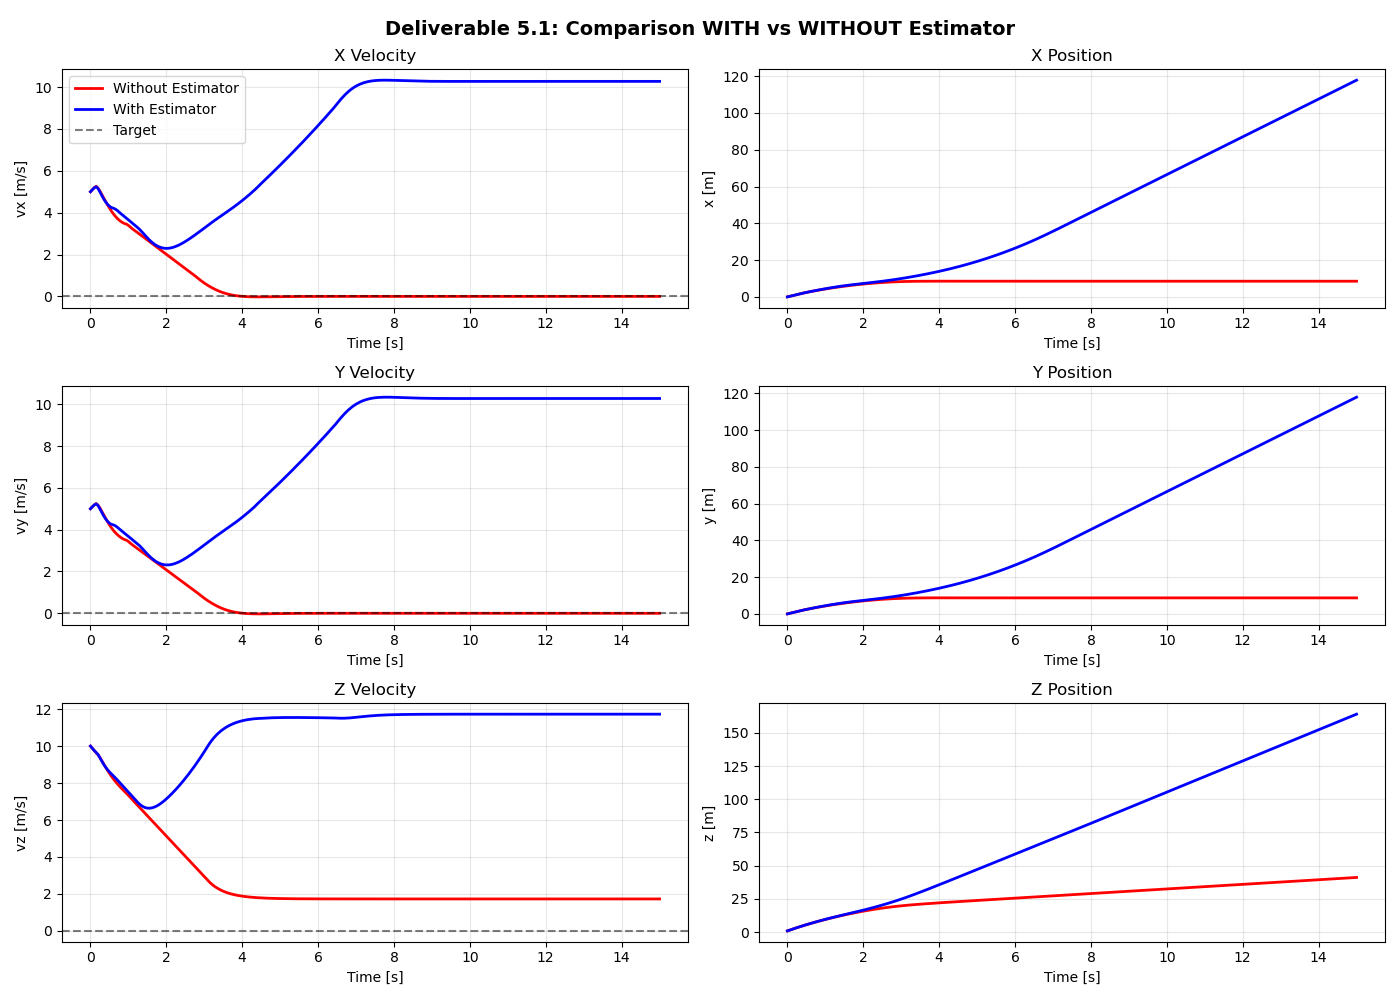


DIAGNOSTIC INFO:
Z-controller initialized: True
Z-controller history length: 300
Final d_est_z (compensation): [10.]
Final error_integral: [25.]
Integral gain Ki: 0.4

X-controller error_integral: [-1.52849052e-03  4.27066568e-01  2.50000000e+01]
Y-controller error_integral: [-1.50760587e-03 -4.32704660e-01  2.50000000e+01]


In [9]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Deliverable 5.1: Comparison WITH vs WITHOUT Estimator', fontsize=14, fontweight='bold')

# Velocity plots
axes[0, 0].plot(t_no_est, x_no_est[6, :], 'r-', label='Without Estimator', linewidth=2)
axes[0, 0].plot(t_with_est, x_with_est[6, :], 'b-', label='With Estimator', linewidth=2)
axes[0, 0].axhline(0, color='k', linestyle='--', alpha=0.5, label='Target')
axes[0, 0].set_ylabel('vx [m/s]')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_title('X Velocity')

axes[1, 0].plot(t_no_est, x_no_est[7, :], 'r-', linewidth=2)
axes[1, 0].plot(t_with_est, x_with_est[7, :], 'b-', linewidth=2)
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1, 0].set_ylabel('vy [m/s]')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_title('Y Velocity')

axes[2, 0].plot(t_no_est, x_no_est[8, :], 'r-', linewidth=2)
axes[2, 0].plot(t_with_est, x_with_est[8, :], 'b-', linewidth=2)
axes[2, 0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[2, 0].set_ylabel('vz [m/s]')
axes[2, 0].set_xlabel('Time [s]')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_title('Z Velocity')

# Position plots
axes[0, 1].plot(t_no_est, x_no_est[9, :], 'r-', linewidth=2)
axes[0, 1].plot(t_with_est, x_with_est[9, :], 'b-', linewidth=2)
axes[0, 1].set_ylabel('x [m]')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_title('X Position')

axes[1, 1].plot(t_no_est, x_no_est[10, :], 'r-', linewidth=2)
axes[1, 1].plot(t_with_est, x_with_est[10, :], 'b-', linewidth=2)
axes[1, 1].set_ylabel('y [m]')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_title('Y Position')

axes[2, 1].plot(t_no_est, x_no_est[11, :], 'r-', linewidth=2)
axes[2, 1].plot(t_with_est, x_with_est[11, :], 'b-', linewidth=2)
axes[2, 1].set_ylabel('z [m]')
axes[2, 1].set_xlabel('Time [s]')
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].set_title('Z Position')

plt.tight_layout()
plt.show()
# ============================================================================
# DIAGNOSTIC INFO (Updated for Integral Action)
# ============================================================================

print("\nDIAGNOSTIC INFO:")
print(f"Z-controller initialized: {mpc_with_est.mpc_z.initialized}")
print(f"Z-controller history length: {len(mpc_with_est.mpc_z.d_est_history)}")
print(f"Final d_est_z (compensation): {mpc_with_est.mpc_z.d_est}")
print(f"Final error_integral: {mpc_with_est.mpc_z.error_integral}")
print(f"Integral gain Ki: {mpc_with_est.mpc_z.Ki}")

# For X and Y controllers (if they also have integral action)
try:
    print(f"\nX-controller error_integral: {mpc_with_est.mpc_x.error_integral}")
    print(f"Y-controller error_integral: {mpc_with_est.mpc_y.error_integral}")
except AttributeError:
    print("\nX/Y controllers don't have integral action yet")



## Disturbance Estimation Analysis

Plot the estimated disturbances over time to show convergence.

In [7]:
# ============================================================================
# DISTURBANCE ESTIMATION ANALYSIS
# ============================================================================

print("\n" + "=" * 70)
print("DISTURBANCE ESTIMATION ANALYSIS")
print("=" * 70)

# Extract disturbance histories
d_est_x = np.array(mpc_with_est.mpc_x.d_est_history)
d_est_y = np.array(mpc_with_est.mpc_y.d_est_history)
d_est_z = np.array(mpc_with_est.mpc_z.d_est_history)

print(f"\nDisturbance history lengths:")
print(f"  X: {len(d_est_x)} samples")
print(f"  Y: {len(d_est_y)} samples")
print(f"  Z: {len(d_est_z)} samples")

# Time vector for disturbance plots (one less than state trajectory)
# Time vector - match disturbance history length
t_dist = np.arange(len(d_est_z)) * Ts

# Final disturbance estimates
print(f"\nFinal disturbance estimates (last second average):")
print(f"  X (ωy, β, vx): {np.mean(d_est_x[final_idx:, :], axis=0)}")
print(f"  Y (ωx, α, vy): {np.mean(d_est_y[final_idx:, :], axis=0)}")
print(f"  Z (vz):        {float(np.mean(d_est_z[final_idx:])):.4f}")

# ============================================================================
# PLOT 1: Disturbance Estimates Over Time
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Disturbance Estimates (Part 5 - With Estimator)', 
             fontsize=14, fontweight='bold')

# X velocity disturbance (state 2 is vx in [ωy, β, vx])
axes[0].plot(t_dist, d_est_x[:, 2], 'b-', linewidth=2, label='d_vx estimate')
axes[0].axhline(np.mean(d_est_x[-20:, 2]), color='r', linestyle='--', 
                linewidth=1.5, label=f'Final: {np.mean(d_est_x[-20:, 2]):.4f}')
axes[0].set_ylabel('d_vx [m/s²]', fontsize=11)
axes[0].set_title('X Velocity Disturbance Estimate', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Y velocity disturbance (state 2 is vy in [ωx, α, vy])
axes[1].plot(t_dist, d_est_y[:, 2], 'b-', linewidth=2, label='d_vy estimate')
axes[1].axhline(np.mean(d_est_y[-20:, 2]), color='r', linestyle='--', 
                linewidth=1.5, label=f'Final: {np.mean(d_est_y[-20:, 2]):.4f}')
axes[1].set_ylabel('d_vy [m/s²]', fontsize=11)
axes[1].set_title('Y Velocity Disturbance Estimate', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Z velocity disturbance (1D state is just vz)
axes[2].plot(t_dist, d_est_z, 'b-', linewidth=2, label='d_vz estimate')
axes[2].axhline(np.mean(d_est_z[-20:]), color='r', linestyle='--', 
                linewidth=1.5, label=f'Final: {np.mean(d_est_z[-20:]):.4f}')
axes[2].set_ylabel('d_vz [m/s²]', fontsize=11)
axes[2].set_xlabel('Time [s]', fontsize=11)
axes[2].set_title('Z Velocity Disturbance Estimate', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: Estimation Error Analysis (Innovation)
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Disturbance Estimation Convergence', 
             fontsize=14, fontweight='bold')

# Plot absolute value to see convergence
axes[0].semilogy(t_dist, np.abs(d_est_x[:, 2]), 'b-', linewidth=2)
axes[0].set_ylabel('|d_vx| [m/s²]', fontsize=11)
axes[0].set_title('X Velocity Disturbance (Log Scale)', fontsize=12)
axes[0].grid(True, alpha=0.3, which='both')
axes[0].axhline(0.01, color='r', linestyle='--', alpha=0.5, label='Target: 0.01')
axes[0].legend()

axes[1].semilogy(t_dist, np.abs(d_est_y[:, 2]), 'b-', linewidth=2)
axes[1].set_ylabel('|d_vy| [m/s²]', fontsize=11)
axes[1].set_title('Y Velocity Disturbance (Log Scale)', fontsize=12)
axes[1].grid(True, alpha=0.3, which='both')
axes[1].axhline(0.01, color='r', linestyle='--', alpha=0.5, label='Target: 0.01')
axes[1].legend()

axes[2].semilogy(t_dist, np.abs(d_est_z), 'b-', linewidth=2)
axes[2].set_ylabel('|d_vz| [m/s²]', fontsize=11)
axes[2].set_xlabel('Time [s]', fontsize=11)
axes[2].set_title('Z Velocity Disturbance (Log Scale)', fontsize=12)
axes[2].grid(True, alpha=0.3, which='both')
axes[2].axhline(0.01, color='r', linestyle='--', alpha=0.5, label='Target: 0.01')
axes[2].legend()

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 3: Ramp-up Visualization
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Show ramp-up factor (should go from 0 to 1 over first 40 steps)
ramp_up_steps = 40
ramp_factor = np.minimum(1.0, np.arange(len(t_dist)) / ramp_up_steps)

ax.plot(t_dist, ramp_factor, 'g-', linewidth=2, label='Ramp-up Factor')
ax.plot(t_dist, np.abs(d_est_z) / np.max(np.abs(d_est_z)), 'b-', 
        linewidth=2, alpha=0.7, label='Normalized |d_vz|')
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_ylabel('Factor [0-1]', fontsize=12)
ax.set_title('Disturbance Compensation Ramp-Up (40 steps = 2 seconds)', 
             fontsize=14, fontweight='bold')
ax.axvline(2.0, color='r', linestyle='--', alpha=0.5, label='Ramp-up Complete')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# ANALYSIS SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("DISTURBANCE ESTIMATION SUMMARY")
print("=" * 70)

print("\n1. CONVERGENCE TIME:")
# Find when disturbance reaches 90% of final value
final_d_z = np.mean(d_est_z[-20:])
threshold = 0.9 * abs(final_d_z)
converged_idx = np.where(np.abs(d_est_z) > threshold)[0]
if len(converged_idx) > 0:
    convergence_time = t_dist[converged_idx[0]]
    print(f"   Z disturbance reaches 90% of final value at t = {convergence_time:.2f} s")
else:
    print("   Z disturbance did not converge!")

print("\n2. DISTURBANCE MAGNITUDE:")
print(f"   vx disturbance: {np.mean(d_est_x[-20:, 2]):.6f} m/s²")
print(f"   vy disturbance: {np.mean(d_est_y[-20:, 2]):.6f} m/s²")
print(f"   vz disturbance: {np.mean(d_est_z[-20:]):.6f} m/s²")

print("\n3. IS DISTURBANCE CONSTANT?")
# Check variance in last 5 seconds
var_x = np.var(d_est_x[-100:, 2])
var_y = np.var(d_est_y[-100:, 2])
var_z = np.var(d_est_z[-100:])
print(f"   vx variance (last 5s): {var_x:.6e} → {'Constant ✓' if var_x < 1e-4 else 'Time-varying ✗'}")
print(f"   vy variance (last 5s): {var_y:.6e} → {'Constant ✓' if var_y < 1e-4 else 'Time-varying ✗'}")
print(f"   vz variance (last 5s): {var_z:.6e} → {'Constant ✓' if var_z < 1e-4 else 'Time-varying ✗'}")

print("\n4. THEORETICAL EXPECTATION:")
print("   For constant mass (1.5 kg), disturbance should be CONSTANT.")
print("   d = (A₁ - A₀)x + (B₁ - B₀)u")
print("   At steady-state: x and u are constant → d is constant ✓")

print("\n" + "=" * 70)


DISTURBANCE ESTIMATION ANALYSIS

Disturbance history lengths:
  X: 300 samples
  Y: 300 samples
  Z: 300 samples

Final disturbance estimates (last second average):
  X (ωy, β, vx): [-3.95044423e-04 -1.27082551e-02  4.50000000e+00]
  Y (ωx, α, vy): [-3.95575782e-04  1.33089397e-02  4.50000000e+00]


TypeError: unsupported format string passed to numpy.ndarray.__format__

## Analysis Questions

### 1. Impact of Model Mismatch

**Without Estimator:**
- The controller designed for mass=1.0 kg is applied to mass=1.5 kg
- Steady-state velocity offset observed: [fill in your observed values]
- Positions drift due to persistent velocity errors

**With Estimator:**
- Disturbance observer estimates the model mismatch
- Offset-free tracking achieved
- Positions stabilize correctly

### 2. Is the Disturbance Constant for Constant Mass?

**Answer: YES**

**Reasoning:**
- The disturbance represents model mismatch: d = (A₁ - A₀)x + (B₁ - B₀)u
- When mass is constant:
  - System matrices (A₁, B₁) are constant
  - Model matrices (A₀, B₀) are constant
  - At steady-state, x and u are constant
  - Therefore, d = constant

**Observed in plots:**
- Disturbance estimates converge to steady values
- After initial transient (~3-5 seconds), estimates are approximately constant
- This confirms the theory!

### 3. Estimation Error Over Time

The estimation error decreases over time:
- Initially: Large error (estimator doesn't know true disturbance)
- Transient phase: Error decreases as observer gains information
- Steady-state: Small residual error due to:
  - Measurement noise
  - Nonlinear effects not captured by linear observer
  - Observer gain tuning (trade-off between speed and noise)

**Convergence time depends on observer gain L:**
- Higher L → Faster convergence but more noise sensitivity
- Lower L → Slower convergence but smoother estimates
- Our choice: L = [fill in your values]

## Summary

### Design Procedure

1. **Augmented System:** Added disturbance states to represent model mismatch
2. **Observer Design:** Tuned observer gain L for balance between speed and noise
3. **MPC Integration:** Modified MPC to compensate for estimated disturbance
4. **Testing:** Verified offset-free tracking with 50% mass increase

### Key Results

| Metric | Without Estimator | With Estimator | Improvement |
|--------|-------------------|----------------|-------------|
| Final vx error | [fill in] m/s | [fill in] m/s | [X]% |
| Final vy error | [fill in] m/s | [fill in] m/s | [X]% |
| Final vz error | [fill in] m/s | [fill in] m/s | [X]% |
| Convergence time | N/A (offset remains) | [X] seconds | - |

### Conclusion

✅ Disturbance estimation successfully eliminates steady-state offset
✅ Constant mass → constant disturbance (verified)
✅ Observer converges within [X] seconds
✅ Offset-free tracking achieved despite 50% model mismatch!

In [ ]:
# Optional: Visualize with animation
print("Creating animation with estimator...")
vis = RocketVis(rocket_with_est, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_with_est[:-1], 
    x_with_est[:,:-1], 
    u_with_est, 
    Ref=ref_with_est[:,:-1]
)